<a href="https://colab.research.google.com/github/Harsh-Git-Hub/suicide-data-clustering/blob/master/GAN_and_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 18.9MB/s 


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_docs.vis.embed as embed

import numpy as np

import matplotlib.pyplot as plt
import glob
import imageio

#Utils

In [8]:
def create_gif_animation(anim_file_name, img_path):
    anim_file = anim_file_name
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('{}/image*.png'.format(img_path))
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
    return anim_file

#Data Handler

In [ ]:
class DataHandler:
    def __init__(self, name='handler'):
        self.name = name

    def load_data(name='mnist', add_axis=True):
        if not name:
            raise TypeError("Expected name to be a %r"%type(str))

        available_data = set(["cifar10", "cifar100", "mnist", 
                              "fashion_mnist"])

        name = name.lower()
        if name not in available_data:
            raise ValueError("Dataset not available. Available datasets are\n",
                             available_data)

        if name == 'cifar10':
            (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
        elif name =='fashion_mnist':
            (x_train, _), (x_test, _) = tf.keras.datasets.fashionn_mnist.load_data()
        elif name == 'cifar100':
            (x_train, _), (x_test, _) = tf.keras.datasets.cifar100.load_data()
        else:
            (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

        x_train = x_train.astype('float32') / 255.
        x_test = x_test.astype('float32') / 255.

        if add_axis:
            x_train = x_train[..., tf.newaxis]
            x_test = x_test[..., tf.newaxis]

        return x_train, x_test

In [3]:
# ds = tfds.load('cifar10', split='train')

handler = DataHandler("myhandler")

x_train, x_test = handler.load_data()

print (x_train.shape)
print (x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., 
                                 clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., 
                                clip_value_max=1.)

print (x_train_noisy.shape)
print (x_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
# train_images = []
# for x in ds.as_numpy_iterator():
#     train_images.append(x['image'])

# print(len(train_images), train_images[0].shape)

In [6]:
# BUFFER_SIZE = 180000
# BATCH_SIZE = 128

In [7]:
# train_dataset = tf.data.Dataset.from_tensor_slices(
#     train_images
# ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#AutoEncoder

##Encoder

In [ ]:
def get_encoder(input_shape):
    model = tf.keras.Sequential(name='encoder')
    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Conv2D(16, 
                            (3,3), 
                            activation='relu', 
                            padding='same', 
                            strides=2,
                            name='enc_conv2d_1'))
    
    model.add(tf.keras.layers.Conv2D(8, 
                            (3,3), 
                            activation='relu', 
                            padding='same', 
                            strides=2,
                            name='enc_conv2d_2'))
    return model

In [ ]:
encoder = get_encoder(x_train.shape[1:])

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv2d_1 (Conv2D)        (None, 14, 14, 16)        160       
_________________________________________________________________
enc_conv2d_2 (Conv2D)        (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


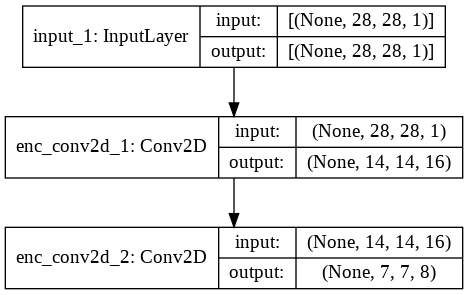

In [ ]:
encoder.summary()

tf.keras.utils.plot_model(
    encoder,
    show_shapes=True,
    show_layer_names=True
)

##Decoder

In [ ]:
def get_decoder(input_shape, op_dims):
    model = tf.keras.Sequential(
        [
         tf.keras.layers.Input(shape=input_shape),
         tf.keras.layers.Conv2DTranspose(8, 
                                         kernel_size=3, 
                                         strides=2, 
                                         activation='relu', 
                                         padding='same',
                                         name='dec_conv2d_trans_1'),
         tf.keras.layers.Conv2DTranspose(16, 
                                         kernel_size=3, 
                                         strides=2, 
                                         activation='relu', 
                                         padding='same',
                                         name='dec_conv2d_trans_2'),
         tf.keras.layers.Conv2D(op_dims, 
                                kernel_size=(3,3), 
                                activation='sigmoid', 
                                padding='same',
                                name='dec_conv2d_1')
         ],
         name='decoder'
    )

    return model

In [ ]:
decoder = get_decoder(encoder.output_shape[1:], 1)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_conv2d_trans_1 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
dec_conv2d_trans_2 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
dec_conv2d_1 (Conv2D)        (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


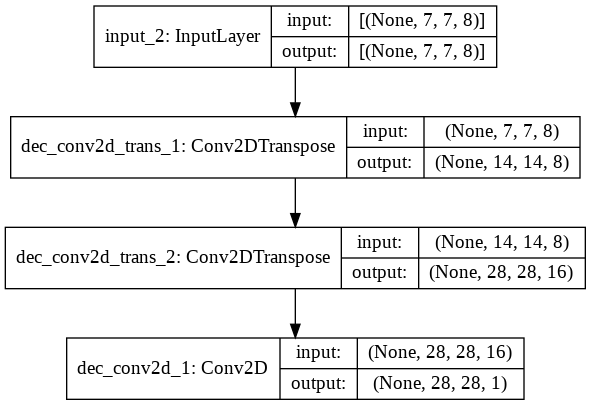

In [ ]:
decoder.summary()

tf.keras.utils.plot_model(
    decoder,
    show_shapes=True,
    show_layer_names=True
)

##DenoisingAutoEncoder

In [ ]:
class DenoisingAutoEncoder(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(DenoisingAutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    # def compile(self, opts_fn, loss_fn):
    #     super(DenoisingAutoEncoder, self).compile()
    #     self.opts_fn = opts_fn
    #     self.loss_fn = loss_fn

    # def train_step(self, inputs):
    #     with tf.GradientTape() as tape:
    #         compressed_vector = self.encoder(inputs)
    #         out = self.decoder(compressed_vector)
            
    #         loss = self.loss_fn(inputs, out)
        
    #     vars = self.encoder.trainable_variables \
    #     + self.decoder.trainable_variables

    #     grads = tape.gradient(loss, vars)
    #     self.opts_fn.apply_gradients(zip(grads, vars))
    #     return {"loss":loss}

    def call(self, inputs):
        compressed_vector = self.encoder(inputs)
        return self.decoder(compressed_vector)

In [ ]:
denoiser = DenoisingAutoEncoder(encoder, decoder)

In [ ]:
denoiser.compile(optimizer='adam', 
                 loss=tf.keras.losses.MeanSquaredError())

In [ ]:
class ImageQualityMonitor(tf.keras.callbacks.Callback):
    def __init__(self, filepath, test, **kwargs):
        super(ImageQualityMonitor, self).__init__(**kwargs)
        self.filepath = filepath
        self.test = test
    
    def on_epoch_end(self, epoch, logs=None):
        encoded_imgs = denoiser.encoder(self.test).numpy()
        decoded_imgs = denoiser.decoder(encoded_imgs).numpy()
        
        fig = plt.figure(figsize=(3,3))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
            plt.axis('off')
        
        plt.savefig('{}/image_at_epoch_{:04d}.png'.format(self.filepath, 
                                                          epoch))

In [ ]:
img_monitor = ImageQualityMonitor(
    'gif_images',
    x_test_noisy[:9]
)

###Training

Epoch 1/25
1875/1875 [==============================] - 9s 3ms/step - loss: 0.0456 - val_loss: 0.0041
Epoch 2/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 3/25
  40/1875 [..............................] - ETA: 4s - loss: 0.0037

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 11/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 12/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0031 - val_l

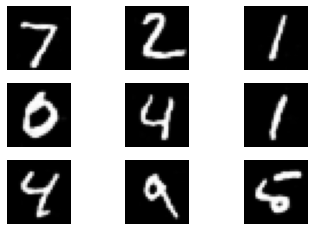

In [ ]:
denoiser.fit(x_train_noisy, x_train, 
             epochs=25,
             shuffle=True,
             validation_data=(x_test_noisy, x_test),
             callbacks=[img_monitor]
)

###Evaluation

In [ ]:
encoded_imgs = denoiser.encoder(x_test).numpy()
decoded_imgs = denoiser.decoder(encoded_imgs).numpy()

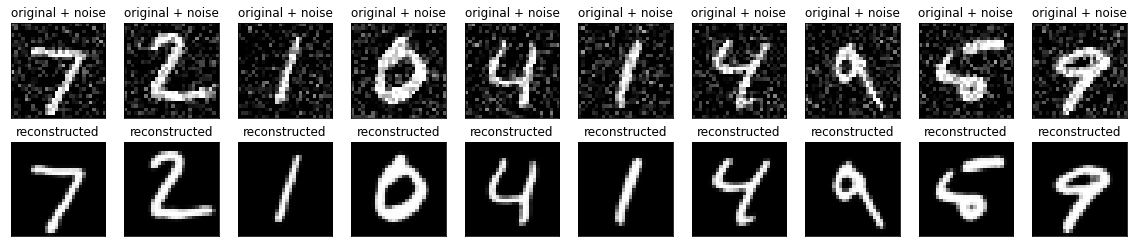

In [ ]:
n = 10
fig = plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

In [ ]:
anim_file = create_gif_animation("denoise.gif", "gif_images")


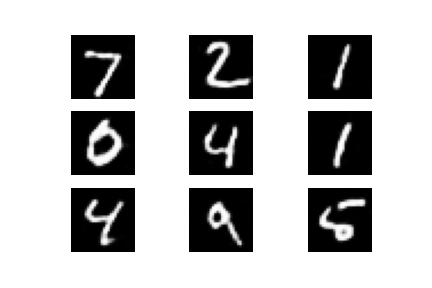

In [ ]:
embed.embed_file(anim_file)

#GAN

##Generator

In [12]:
def get_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, 
                                    input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, 
                                     activation='tanh'))
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

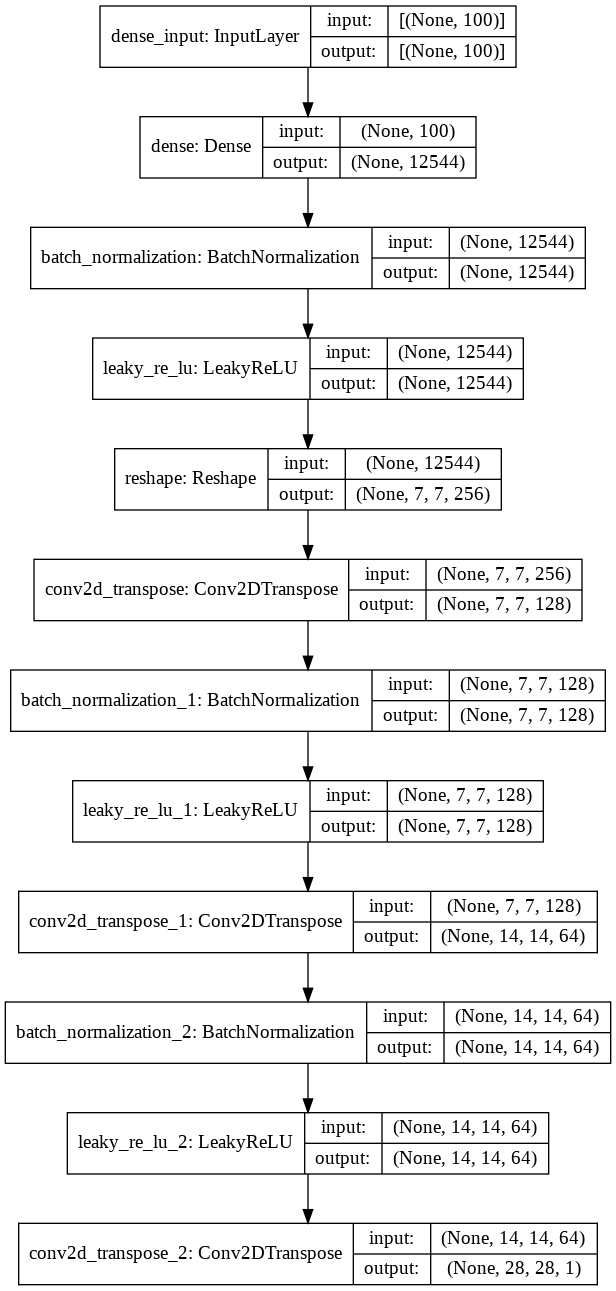

In [13]:
generator = get_generator()

generator.summary()

tf.keras.utils.plot_model(
    generator,
    show_shapes=True
)

##Discriminator

In [14]:
def get_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), 
                                     padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), 
                                     strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

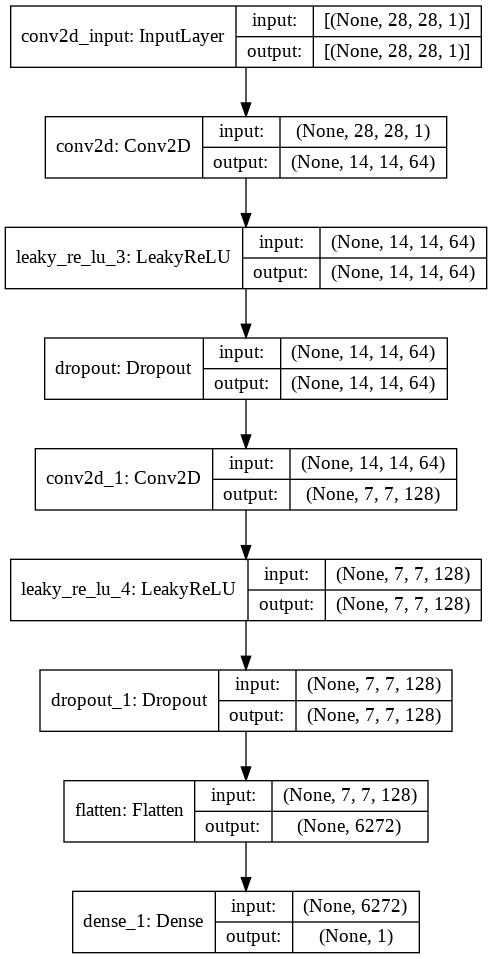

In [15]:
discriminator = get_discriminator()

discriminator.summary()

tf.keras.utils.plot_model(
    discriminator,
    show_shapes=True
)

In [16]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

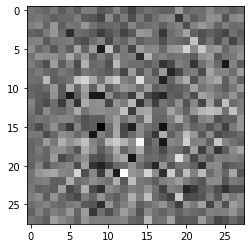

In [17]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [18]:
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00092776]], dtype=float32)>

##GAN Data

In [42]:
BATCH_SIZE = 128

In [43]:
gan_train_data = tf.data.Dataset.from_tensor_slices(
    tf.convert_to_tensor(x_train)
).shuffle(120000).batch(BATCH_SIZE, drop_remainder=True)

gan_train_data

<BatchDataset shapes: (128, 28, 28, 1), types: tf.float32>

##GAN Utils

In [48]:
class ImageQualityMonitorGAN(tf.keras.callbacks.Callback):
    def __init__(self, gan, filepath, test, **kwargs):
        super(ImageQualityMonitorGAN, self).__init__(**kwargs)
        self.gan = gan
        self.filepath = filepath
        self.test = test
    
    def on_epoch_end(self, epoch, logs=None):
        predictions = self.gan.generator(self.test, training=False)

        fig = plt.figure(figsize=(3, 3))

        for i in range(predictions.shape[0]):
            plt.subplot(3, 3, i + 1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
            plt.ioff()

        plt.savefig('{}/image_at_epoch_{:04d}.png'.format(self.filepath, 
                                                          epoch))
        plt.close(fig)

def visualize_gan_loss(gan_history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)
    ax[0].plot(gan_history.history["gen_loss"])
    ax[0].grid()
    ax[0].set_title("Generator Loss", fontdict={"size":14})

    ax[1].plot(gan_history.history["disc_loss"])
    ax[1].grid()
    ax[1].set_title("Discriminator Loss", fontdict={"size":14})

    fig.text(x=0.5, y=0.01, s="Epochs")

    fig.tight_layout()

##DCGAN

In [ ]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, 
                 batch_size, noise_dim, **kwargs):
        super(DCGAN, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.noise_dim = noise_dim

    def compile(self, g_opts, d_opts, g_loss_fn, d_loss_fn):
        super(DCGAN, self).compile()
        self.g_opts = g_opts
        self.d_opts = d_opts
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn

    def train_step(self, inputs):
        noise = tf.random.normal([self.batch_size, self.noise_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_image = generator(noise, training=True)

            real_out = discriminator(inputs, training=True)
            fake_out = discriminator(generated_image, training=True)

            gen_loss = self.g_loss_fn(fake_out)
            disc_loss = self.d_loss_fn(real_out, fake_out)

        gen_vars = self.generator.trainable_variables
        disc_vars = self.discriminator.trainable_variables

        gen_grads = gen_tape.gradient(gen_loss, gen_vars)
        self.g_opts.apply_gradients(zip(gen_grads, gen_vars))

        disc_grads = disc_tape.gradient(disc_loss, disc_vars)
        self.d_opts.apply_gradients(zip(disc_grads, disc_vars))

        return {"gen_loss":gen_loss, "disc_loss":disc_loss}

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
dcgan = DCGAN(generator, discriminator, 128, 100)

In [ ]:
dcgan.compile(
    g_opts=generator_optimizer,
    d_opts=discriminator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss
)

###Training

Epoch 1/100
469/469 [==============================] - 15s 30ms/step - gen_loss: 1.2186 - disc_loss: 0.9888
Epoch 2/100
469/469 [==============================] - 14s 31ms/step - gen_loss: 0.8052 - disc_loss: 1.2168
Epoch 3/100
469/469 [==============================] - 15s 31ms/step - gen_loss: 1.0134 - disc_loss: 0.9833
Epoch 4/100
469/469 [==============================] - 15s 31ms/step - gen_loss: 1.2075 - disc_loss: 0.8572
Epoch 5/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 1.5059 - disc_loss: 0.7136
Epoch 6/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 1.6740 - disc_loss: 0.6589
Epoch 7/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 1.7965 - disc_loss: 0.6264
Epoch 8/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 1.9185 - disc_loss: 0.5864
Epoch 9/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.0201 - disc_loss: 0.5665
Epoch 10/100
469/469 [======

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


Epoch 22/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.3565 - disc_loss: 0.5135
Epoch 23/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.3962 - disc_loss: 0.5042
Epoch 24/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.4326 - disc_loss: 0.4954
Epoch 25/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.4467 - disc_loss: 0.4871
Epoch 26/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.4435 - disc_loss: 0.4891
Epoch 27/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.4682 - disc_loss: 0.4834
Epoch 28/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.4750 - disc_loss: 0.4818
Epoch 29/100
469/469 [==============================] - 15s 33ms/step - gen_loss: 2.5030 - disc_loss: 0.4767
Epoch 30/100
469/469 [==============================] - 15s 32ms/step - gen_loss: 2.5098 - disc_loss: 0.4728
Epoch 31/100
469/46

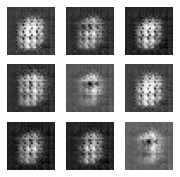

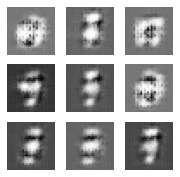

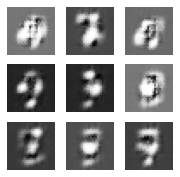

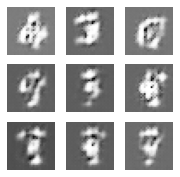

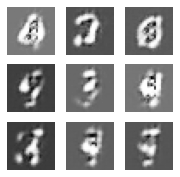

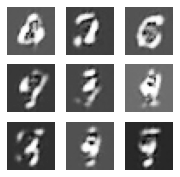

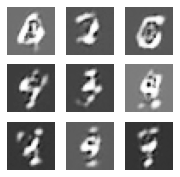

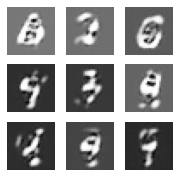

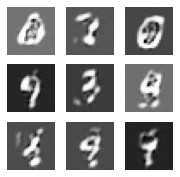

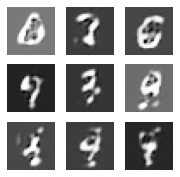

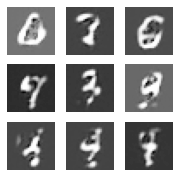

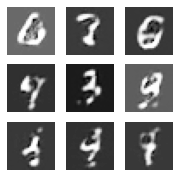

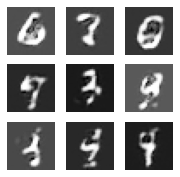

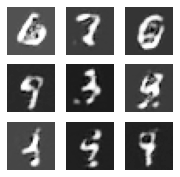

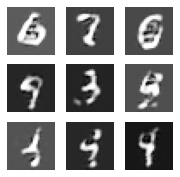

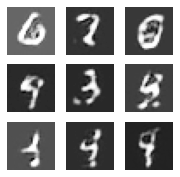

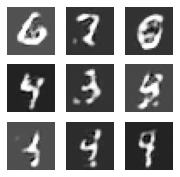

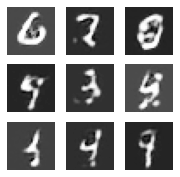

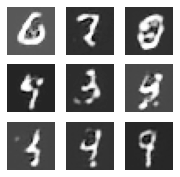

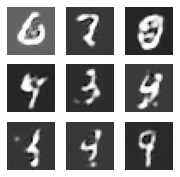

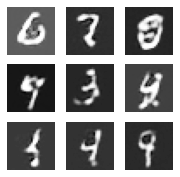

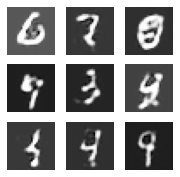

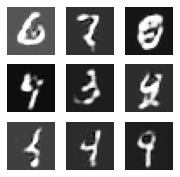

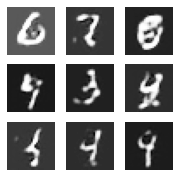

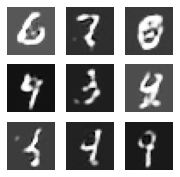

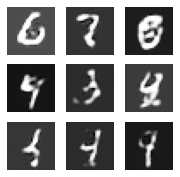

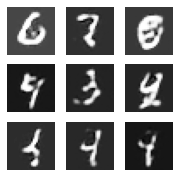

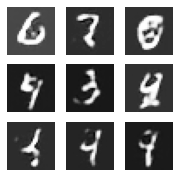

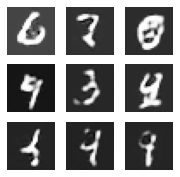

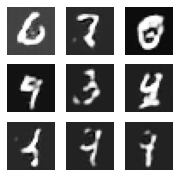

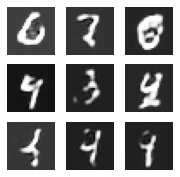

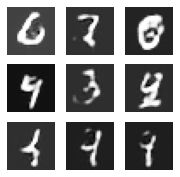

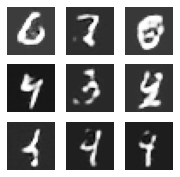

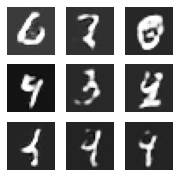

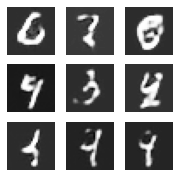

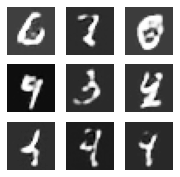

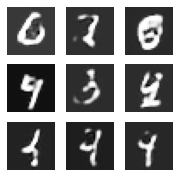

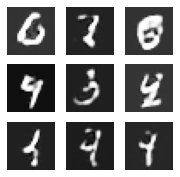

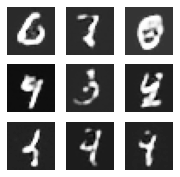

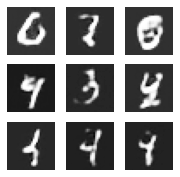

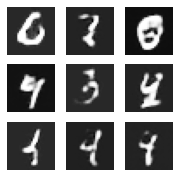

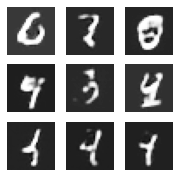

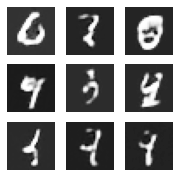

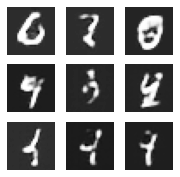

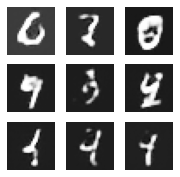

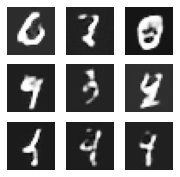

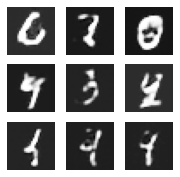

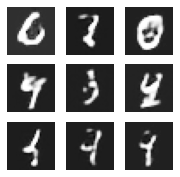

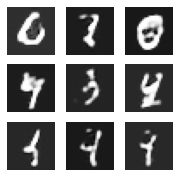

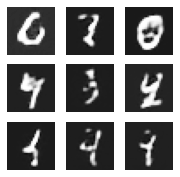

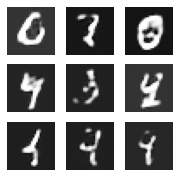

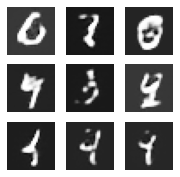

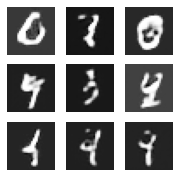

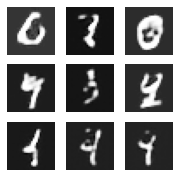

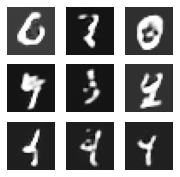

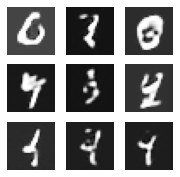

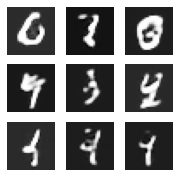

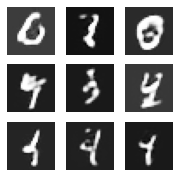

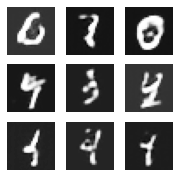

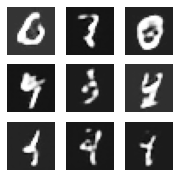

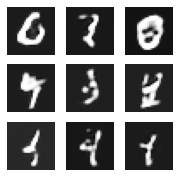

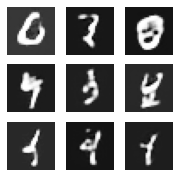

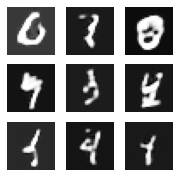

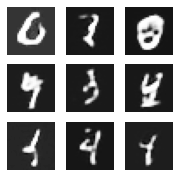

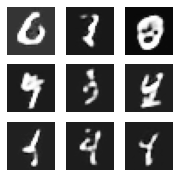

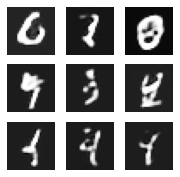

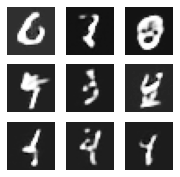

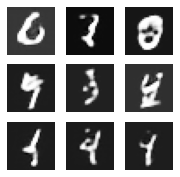

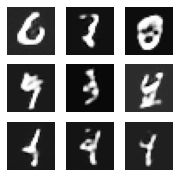

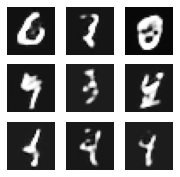

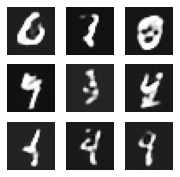

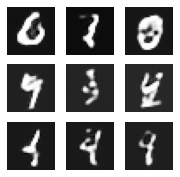

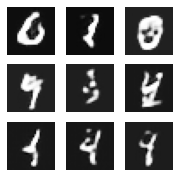

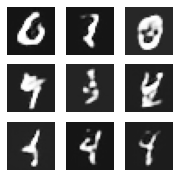

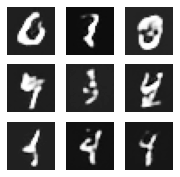

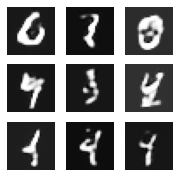

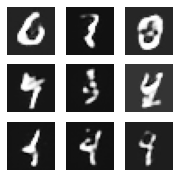

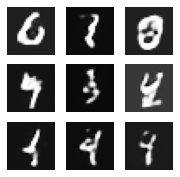

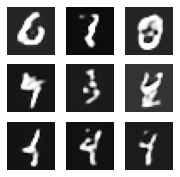

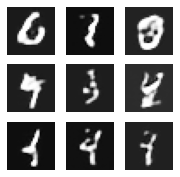

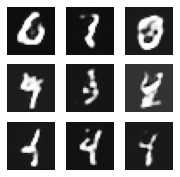

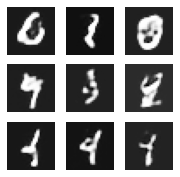

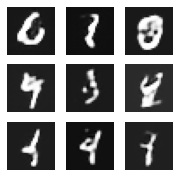

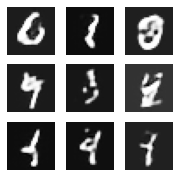

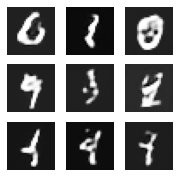

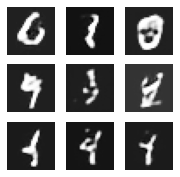

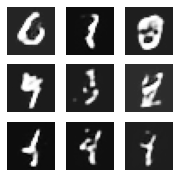

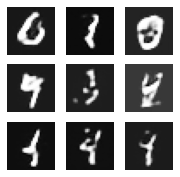

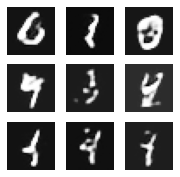

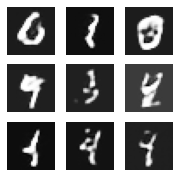

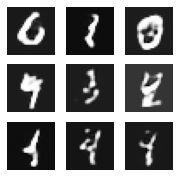

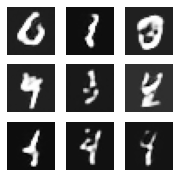

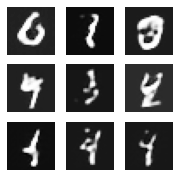

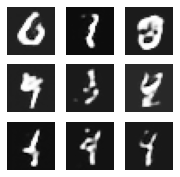

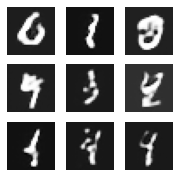

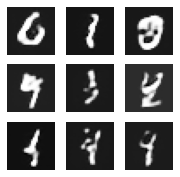

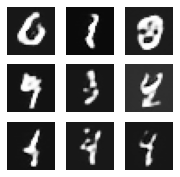

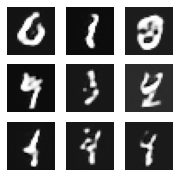

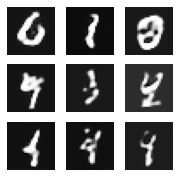

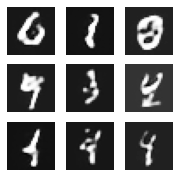

In [ ]:
dcgan_history = dcgan.fit(gan_train_data, 
          epochs=100,
          callbacks=[gan_monitor])

###Evaluation

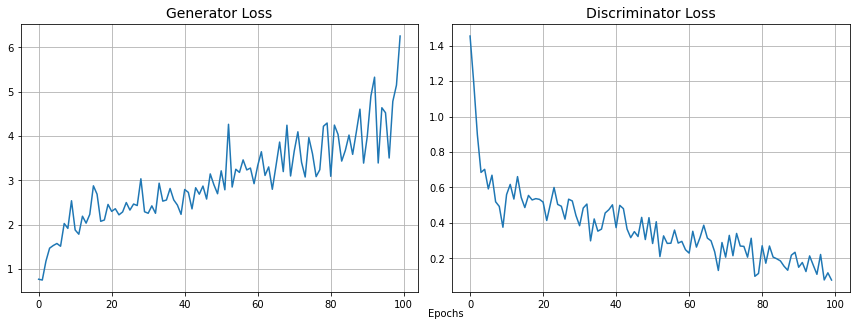

In [ ]:
visualize_gan_loss(dcgan_history)

In [ ]:
anim_file = create_gif_animation("gan_images.gif", "gan_images")


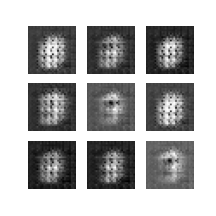

In [ ]:
embed.embed_file(anim_file)

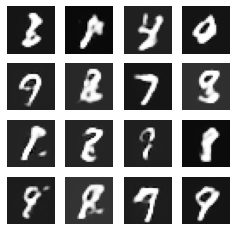

In [ ]:
predictions = dcgan.generator(tf.random.normal([16, 100]))

fig = plt.figure(figsize=(4, 4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()
plt.close()

##WGAN-GP

In [44]:
class WGAN_GP(tf.keras.Model):
    def __init__(self, generator, discriminator,
                 disc_train_time, batch_size, noise_dim,
                 gp_weight=10., **kwargs):
        
        super(WGAN_GP, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.disc_train_time = disc_train_time
        self.noise_dim = noise_dim
        self.gp_weight = gp_weight

    def compile(self, g_opts, d_opts, g_loss_fn, d_loss_fn):
        super(WGAN_GP, self).compile()
        self.g_opts = g_opts
        self.d_opts = d_opts
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn

    def gradient_penalty(self, real_img, gen_img):
        alpha = tf.random.normal([self.batch_size, 1, 1, 1], 0.0, 1.0)
        diff = gen_img - real_img
        interpolated = real_img + (alpha * diff)
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.math.sqrt(
            tf.math.reduce_sum(tf.math.square(grads), axis=[1, 2, 3])
        )
        gp = tf.math.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, inputs):
        for i in range(self.disc_train_time):
            noise =  tf.random.normal([self.batch_size, self.noise_dim])
            with tf.GradientTape() as tape:
                gen_img = self.generator(noise, training=True)
                
                fake_out = self.discriminator(gen_img, training=True)
                real_out = self.discriminator(inputs, training=True)

                d_cost = self.d_loss_fn(real_out, fake_out)
                gp = self.gradient_penalty(inputs, gen_img)
                d_loss = d_cost + gp * self.gp_weight
                
            d_vars = self.discriminator.trainable_variables
            grads = tape.gradient(d_loss, d_vars)
            self.d_opts.apply_gradients(zip(grads, d_vars))


        noise =  tf.random.normal([self.batch_size, self.noise_dim])
        with tf.GradientTape() as tape:
            gen_img = self.generator(noise, training=True)

            fake_out = self.discriminator(gen_img, training=True)

            g_loss = self.g_loss_fn(fake_out)
            
        g_vars = self.generator.trainable_variables
        grads = tape.gradient(g_loss, g_vars) 
        self.g_opts.apply_gradients(zip(grads, g_vars))

        return {"gen_loss":g_loss, "disc_loss":d_loss}

In [45]:
wgan = WGAN_GP(
    generator,
    discriminator,
    5,
    BATCH_SIZE,
    100
)

In [46]:
def wgan_discriminator_loss(real_img, fake_img):
    real_loss = tf.math.reduce_mean(real_img)
    fake_loss = tf.math.reduce_mean(fake_img)
    return fake_loss - real_loss

def wgan_generator_loss(fake_img):
    return -tf.math.reduce_mean(fake_img)

wgan.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    wgan_generator_loss,
    wgan_discriminator_loss
)

seed = tf.random.normal([9, 100])       
gan_monitor = ImageQualityMonitorGAN(wgan, "gan_images", seed)

###Training

In [47]:
wgan_history = wgan.fit(
    gan_train_data,
    epochs=25,
    callbacks=[gan_monitor])

Epoch 1/25
468/468 [==============================] - 90s 183ms/step - gen_loss: -4.4686 - disc_loss: -1.6022
Epoch 2/25
468/468 [==============================] - 86s 183ms/step - gen_loss: -3.6496 - disc_loss: -1.3990
Epoch 3/25
468/468 [==============================] - 86s 183ms/step - gen_loss: -3.1683 - disc_loss: -1.2524
Epoch 4/25
468/468 [==============================] - 86s 183ms/step - gen_loss: -2.5782 - disc_loss: -1.1256
Epoch 5/25
468/468 [==============================] - 86s 183ms/step - gen_loss: -2.0647 - disc_loss: -1.0410
Epoch 6/25
468/468 [==============================] - 86s 183ms/step - gen_loss: -1.8073 - disc_loss: -0.9610
Epoch 7/25
468/468 [==============================] - 86s 183ms/step - gen_loss: -1.5030 - disc_loss: -0.8904
Epoch 8/25
468/468 [==============================] - 86s 183ms/step - gen_loss: -1.2374 - disc_loss: -0.8376
Epoch 9/25
468/468 [==============================] - 86s 183ms/step - gen_loss: -1.1334 - disc_loss: -0.7888
Epoch 10/2

###Evaluation

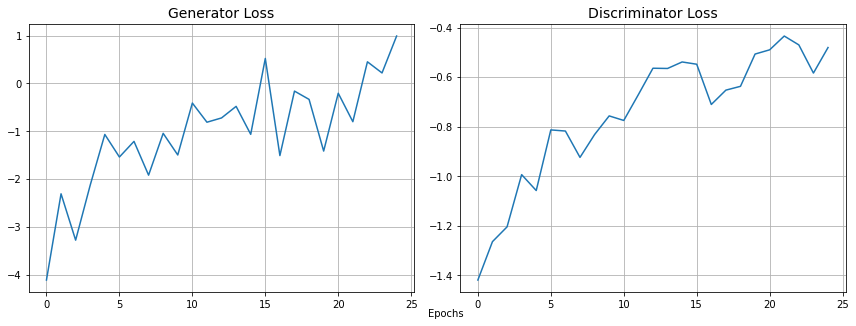

In [49]:
visualize_gan_loss(wgan_history)


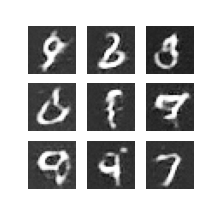

In [50]:
anim_file = create_gif_animation("gan_images.gif", "gan_images")
embed.embed_file(anim_file)